# Environment Configuration

In [1]:
# !pip install torch
# !pip install torchvision
# !pip install plotly
# !pip install numpy
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.6 MB/s eta 0:00:00


In [2]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torch.optim.lr_scheduler import StepLR, ExponentialLR
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
# Data Visualization
import plotly.express as px
# from tqdm.auto import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
# Experimental
from torchvision import models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Data and model will be loaded on the {device}')

Data and model will be loaded on the cpu


# Colon Dataset

In [4]:
s_1 = 0.2
colon_dataset =  datasets.ImageFolder(
    '/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon',
    transform = transforms.Compose([
        # Downscale the image by s_1
        transforms.Resize(int(s_1 * 500)),
        transforms.ColorJitter(),
        transforms.ToTensor()
    ])
    )

In [5]:
loaders = {
    'train' : DataLoader(
    colon_dataset,
    batch_size=5,
    shuffle=True,
    num_workers=1
    )
}

In [6]:
print(colon_dataset.imgs)
data, target = colon_dataset[0]
print(f'Label: {target}')
px.imshow(np.transpose(data, (1, 2, 0)))

# 0 --> Negative
# 1 --> Positive

[('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img1.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img100.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img11.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img12.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img15.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img16.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img2.bmp', 0), ('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/CustomData/Colon/Negative/img23.bmp', 0), ('/content/drive/MyDrive/Graduat

# $a(\theta)$: Attention Map for Down-scaled Input Image

In [ ]:
"""
This is the implementation of a(\theta) defined by the paper appendix with some modifications due to
a lack of details...
"""
class step_1_attention_lenet(nn.Module):
  def __init__(self):
    # Superconstructor to inherit nn.Module Properties
    super(step_1_attention_lenet, self).__init__()
    # Layers
    self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
    self.conv2 = nn.Conv2d(8, 8, 3, 1, 1)
    self.conv3 = nn.Conv2d(8, 1, 3, 1, 1)
    self.average_pooling = nn.AvgPool2d(1)
  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = F.tanh(self.conv2(x))
    x = F.tanh(self.conv3(x))
    x = self.average_pooling(x)
    x = F.softmax(x, dim = 2)
    return x

# $b(\theta)$: Attention Map for Attention Map

In [ ]:
"""
This is the implementation of b(\theta) defined by the paper appendix with some modifications due to
a lack of details...
"""
class step_2_attention_lenet(nn.Module):
  def __init__(self):
    # Superconstructor to inherit nn.Module Properties
    super(step_2_attention_lenet, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
    self.conv2 = nn.Conv2d(8, 8, 3, 1, 1)
    self.conv3 = nn.Conv2d(8, 1, 3, 1, 1)
  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = F.tanh(self.conv2(x))
    x = F.softmax(self.conv3(x), dim = 2)
    return x

## $f(\theta):$ Feature Extractor

In [ ]:
class step_2_feature_extraction(nn.Module):
  def __init__(self):
    # Superconstructor to inherit nn.Module Properties
    super(step_2_feature_extraction, self).__init__()
    self.conv1 = nn.Conv2d(32, 32, 7, 1, 3)
    self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
    self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
    self.average_pooling = nn.AvgPool2d(1)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.average_pooling(x)
    return x

## Classification Module $g(\theta)$

In [ ]:
class step_2_classification(nn.Module):
  def __init__(self):
    # Superconstructor to inherit nn.Modules
    super(step_2_classification, self).__init__()
    self.fc = nn.Linear(32, 2)
  def forward(self, x):
    return self.fc(x)

# Zoom-In Network

In [7]:
class AttentionNetwork(nn.Module):
    def __init__(self):
        super(AttentionNetwork, self).__init__()
        # Input has images of dimension (100 x 100)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 100, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(100 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, 2)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.batch_norm_2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.5)


        # Attention Network applied after the first convolutional layer
        self.attention = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Softmax(dim=-1)
        )


    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = self.batch_norm_1(x)
        x = self.dropout(x)
        """
        Goal: Apply attention after first convolution to get spatial features
          i) Calculate the attention weights
        """
        # Calculate attention weights
        attention_weights = self.attention(x)
        # Normalize attention weights to sum up to 1
        attention_weights = F.normalize(attention_weights, p=1, dim=(2, 3))
        # Incorporate attention into the forward pass
        x = x * attention_weights
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = self.batch_norm_2(x)
        x = self.dropout(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, attention_weights

In [ ]:
# Initialize your model
model = AttentionNetwork()
# Book Keeping
training_loss = []
training_accuracy = []
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    betas = (0.9, 0.999),
    lr = 0.001,
    weight_decay=1e-5
    )
# scheduler = ExponentialLR(optimizer, gamma=0.9)

# Training loop
epochs = 100
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    print(f'Epoch: {epoch}')
    for image, label in tqdm(loaders['train']):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output, attention_weights = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == label).sum().item()
    # scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {round(loss.item(), 2)}")
    print(f"Accuracy:\n\tCorrect: {correct}\n\tSamples: {100}\n\tScore: {round((correct / 100), 2) * 100}")
    # Book Keeping
    training_loss.append(loss.item())
    training_accuracy.append(round(correct / 100, 2) * 100)


In [ ]:
torch.save(model.state_dict(), r'/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/Code/models/model.pt')

In [9]:
fig1 = px.line(
     x = [x for x in range(len(training_loss))],
    y = training_loss,
    labels = {
        'x': 'Step',
        'y': 'Loss',
    },
    title = 'Loss Curve for Training Network'
)
fig1.show()
fig1.write_image('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/Code/Images/training_loss.png')

fig2 = px.line(
    x = [x for x in range(len(training_accuracy))],
    y = training_accuracy,
    labels = {
        'x': 'Epoch',
        'y': 'Accuracy (%)',
    },
    title = 'Accuracy Curve for Training Network'
)
fig2.show()
fig2.write_image('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6322/Course Project/Code/Images/training_accuracy.png')

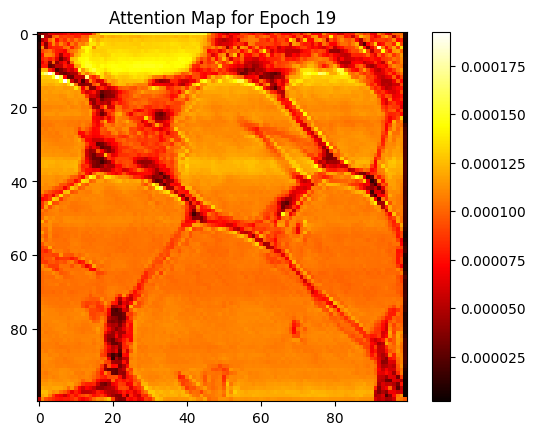

Shape of Attention Map: torch.Size([1, 1, 100, 100])
Attention Map:
tensor([[[[2.5531e-05, 3.8841e-05, 4.3370e-05,  ..., 1.0225e-04,
           1.0280e-04, 7.9110e-06],
          [5.7652e-06, 1.8079e-04, 5.1316e-05,  ..., 8.9204e-05,
           1.0726e-04, 7.3542e-06],
          [5.8755e-06, 5.1089e-05, 6.2330e-05,  ..., 7.1740e-05,
           7.9572e-05, 6.3579e-06],
          ...,
          [9.4770e-06, 1.2537e-04, 1.2493e-04,  ..., 5.9085e-05,
           5.9203e-05, 2.4726e-06],
          [9.4375e-06, 1.1907e-04, 1.2384e-04,  ..., 1.0347e-04,
           1.1330e-04, 2.0082e-06],
          [5.2913e-05, 1.1014e-04, 9.4199e-05,  ..., 1.0715e-04,
           1.0526e-04, 9.7043e-05]]]])


In [ ]:
model.eval()
with torch.no_grad():
  data, target = colon_dataset[0]
  data = data.unsqueeze(0)
  data = data.to(device)
  output, attention_map = model(data)
  # Convert the attention map to a numpy array
  attention_map_numpy = attention_map.squeeze().cpu().numpy()
  # Plot the attention map
  plt.imshow(attention_map_numpy, cmap='hot', interpolation='nearest')
  plt.colorbar()
  plt.title(f'Attention Map for Epoch {epoch}')
  plt.savefig(f'attention_map_epoch_{epoch + 1}.png')
  plt.show()
  print(f'Shape of Attention Map: {attention_map.shape}')
  print(f'Attention Map:\n{attention_map}')